In [1]:
import rebound
import reboundx
import numpy as np
import matplotlib.pyplot as plt

""" TO-DO:
- check prediction vs result of J2 precession
- figure out correct initial conditions/parameters to reach evection resonance
"""

G = (6.67e-11) * (1.989e30) * (2.9744944e-19) # G in units of AU, Msun, yr

# Check accuracy of all the following constants
mSat = 0.0002857 # mass of saturn in solar masses
aSat = 9.5549 # semi-major axis of Saturn's orbit in AU
eSat = 0.0565 # eccentricity of Saturn
rSat = 0.00038926024 # radius of Saturn in AU
j2Sat = 16298e-6 # J2 of Saturn (Murray and Dermott p 531) 
tauTitan = 16/365.25  # period of titan in years ** Check accuracy **
curr_aTitan = 0.008167696467 # semi-major axis of titan in AU
mTitan = 0.0000000676319759 # mass of titan in solar masses
eTitan = 0.001 # eccentricity of Titan's orbit


# Calculate the expected semi-major axis of Titan at which evection resonance should occur given i = e = 0

exp_aRes = np.power((9/4)*j2Sat*j2Sat*mSat*np.power((aSat/rSat),3), (1/7)) # in units of saturn radii

print(exp_aRes)


# Calculate expected precession frequency given i = e = 0 (eqn (3) Spalding_et_al_2016.pdf)
mean_motion_Titan = np.sqrt(G * mSat / (curr_aTitan*curr_aTitan*curr_aTitan))
exp_prec_freq = (3/2)*mean_motion_Titan*j2Sat*(rSat*rSat)/(curr_aTitan*curr_aTitan)
print(1/exp_prec_freq)


8.215180272431718
125.19900958495452


Text(0, 0.5, "Titan's longitude of pericenter")

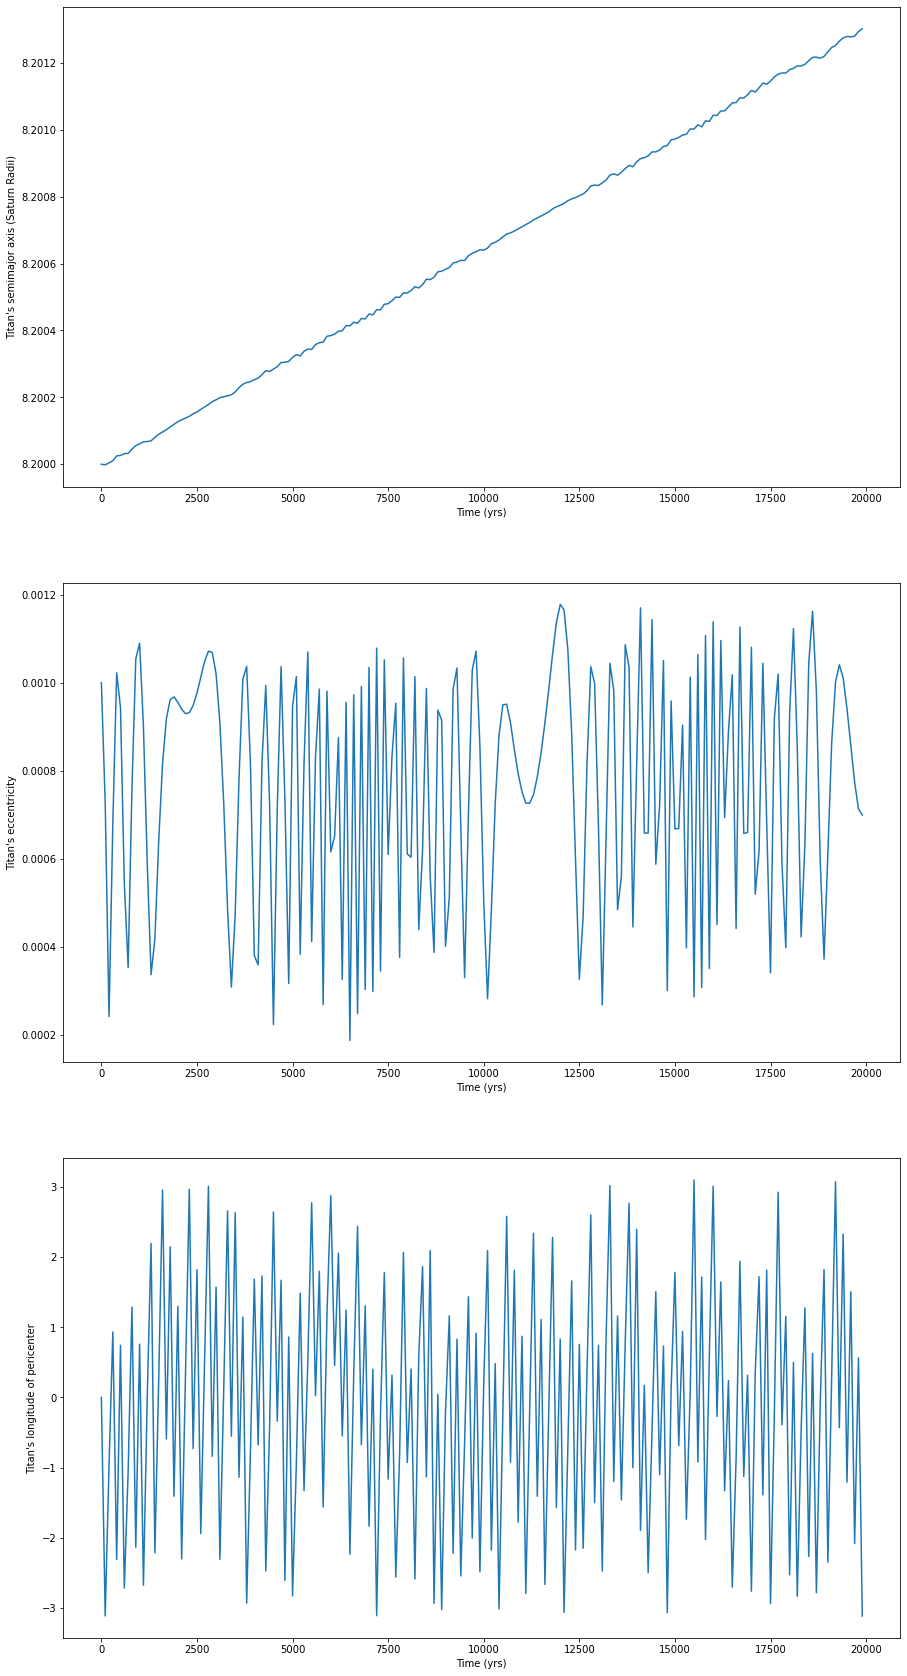

In [9]:
numSamples = 200
totalSimTime = 20000
plotDT = int(totalSimTime/numSamples)

# Initialize rebound simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')

e_array = [0] * numSamples
a_array = [0] * numSamples
pomega_array = [0] * numSamples
time_array = [0] * numSamples

# add Saturn
sim.add(m=mSat)

# add Titan
sim.add(m=mTitan, a=8.2*rSat, e=eTitan)

# add sun (with semi-major axis and eccentricity of Saturn)
sim.add(m=1, a=aSat, e=eSat)

rebx = reboundx.Extras(sim) # Initiate reboundx

# Add the migration force
mod_effect = rebx.load_force("exponential_migration") 
rebx.add_force(mod_effect)
sim.particles[1].params["em_aini"] = 8.2*rSat  # parameter 1: Titan's initial semimajor axis
sim.particles[1].params["em_afin"] = 21*rSat  # parameter 2: Titan's final semimajor axis
sim.particles[1].params["em_tau_a"] = 2e8  # parameter 3: the migration e-folding time

# add Saturn's J2
gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)
sim.particles[0].params["J2"] = j2Sat
sim.particles[0].params["R_eq"] = rSat

sim.integrator = "whfast"
sim.dt = (1/20) * tauTitan # time step = 1/20 * shortest orbital period

for i in range(0,numSamples):   # Integrate the system for 1e4 years
    sim.integrate(i * plotDT)
    a_array[i] = sim.particles[1].a / rSat
    e_array[i] = sim.particles[1].e
    pomega_array[i] = sim.particles[1].pomega
    time_array[i] = sim.t

sim.move_to_hel()

fig, axs = plt.subplots(3)

fig.set_size_inches(15, 30)

axs[0].plot(time_array,a_array)
axs[0].set_xlabel('Time (yrs)')
axs[0].set_ylabel('Titan\'s semimajor axis (Saturn Radii)')

axs[1].plot(time_array,e_array)
axs[1].set_xlabel('Time (yrs)')
axs[1].set_ylabel('Titan\'s eccentricity')

axs[2].plot(time_array,pomega_array)
axs[2].set_xlabel('Time (yrs)')
axs[2].set_ylabel('Titan\'s longitude of pericenter')

# fig = rebound.OrbitPlot(sim, unitlabel="[AU]", color=False, periastron=True)

# ax = plt.subplot(111)
# ax.set_xlim([-.05,.05])
# ax.set_ylim([-.05,.05])

# plt.show()